<a href="https://colab.research.google.com/github/Ifeanyi-Ezeigwe/Skin-Cancer-image-Classifer/blob/main/SID_2193800_ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the necessary Libraries


In [2]:
#import the necessary libraries that we need for this project

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns
from PIL import Image
import tensorflow as tf
import plotly as px

np.random.seed(42)

from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential


from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models


In [3]:
#Reading and loading the HAM10000 dataset into a DataFrame


dir_path = '/content/drive/MyDrive/Colab_files/Neu_Comp/dataverse_files/'
df = pd.read_csv(dir_path + 'HAM10000_metadata')




#Exploratory data Analysis and Visualization




In [4]:
#Firstly we initialize the image size we want to use for this prediction, 
#we have to resize the image from the default size of 600*450 and assume the image size of 32 (32by32)

SIZE = 28

In [5]:
#convert the label values from text to numeric values

le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
#label transformation and create a new column to store the new transformed lables

df['label'] = le.transform(df['dx'])
print(df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
7754          abdomen   vidir_modern      5  
8071    

In [7]:
#lets visualize the first 10 rows of the dataset

df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2


In [8]:
df.shape

(10015, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   label         10015 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 704.3+ KB


In [10]:
#shows the data distribution 

df.describe()

,age,label
count,9958.000000,10015.000000
mean,51.863828,4.182327
std,16.968614,1.458742
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,5.000000
75%,65.000000,5.000000
max,85.000000,6.000000


In [11]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Cell Type', 'Localization', 'Age', 'Sex'))

fig.add_trace(go.Bar(x=df['dx'].value_counts().index,
                     y=df['dx'].value_counts().values,
                     name='Cell Type'), row=1, col=1)
fig.update_xaxes(title_text='Cell Type', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.add_trace(go.Bar(x=df['localization'].value_counts().index,
                     y=df['localization'].value_counts().values,
                     name='Localization'), row=1, col=2)
fig.update_xaxes(title_text='Localization', row=1, col=2)
fig.update_yaxes(title_text='Count', row=1, col=2)

sample_age = df[pd.notnull(df['age'])]
fig.add_trace(go.Histogram(x=sample_age['age'], name='Age', marker_color='red'), row=2, col=1)
fig.update_xaxes(title_text='Age', row=2, col=1)
fig.update_yaxes(title_text='Count', row=2, col=1)

fig.add_trace(go.Bar(x=df['sex'].value_counts().index,
                     y=df['sex'].value_counts().values,
                     name='Sex'), row=2, col=2)
fig.update_xaxes(title_text='Sex', row=2, col=2)
fig.update_yaxes(title_text='Count', row=2, col=2)

fig.update_layout(title='Distribution of Skin Lesion Features',
                  height=600,
                  width=1110,
                  showlegend=True,
                  template='plotly_dark')



In [12]:
#distribution of data into various classes
#Looking at the distribution of the dataset, it obvious that is heavily imbalance
#And this can impair a smooth prediction process

from sklearn.utils import resample
print(df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


#Data Augmentation

In [13]:
#Here, i have to balance the dataset by assuming an equal distribution of 500 per class,
#many ways to balance data... you can also try assigning weights during model implementation
#seperate each classes, resample, and combine back into single dataframe

from sklearn.utils import resample

# Define the number of samples per class
n_samples = 500

# Define an empty DataFrame to store the balanced data
df_balanced = pd.DataFrame()

# Loop over each class
for label in range(7):
    # Get the samples for the current class
    df_class = df[df['label'] == label]
    # Resample the samples to achieve the desired number of samples
    df_class_balanced = resample(df_class, replace=True, n_samples=n_samples, random_state=42)
    # Append the balanced samples to the DataFrame
    df_balanced = pd.concat([df_balanced, df_class_balanced])

# Recheck the distribution of the classes to see if they have balanced up
print(df_balanced['label'].value_counts())


0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [14]:
#Now lets read the images based on image ID from the csv file, ensuring that the right images are read

dir_path = '/content/drive/MyDrive/Colab_files/Neu_Comp/dataverse_files/HAM10000_data'
file_pattern = os.path.join(dir_path, '*', '*.jpg')

image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(file_pattern)}


In [15]:
#define the path and add as a new column
df_balanced['path'] = df['image_id'].map(image_path.get)



In [16]:
#use the path to read the images and examine the added columns in the new restructed dataframe - df_balanced

df_balanced['image'] = df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))


df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,rosendahl,0,/content/drive/MyDrive/Colab_files/Neu_Comp/da...,"[[[154, 116, 104], [164, 128, 121], [175, 141,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,0,/content/drive/MyDrive/Colab_files/Neu_Comp/da...,"[[[137, 75, 81], [132, 65, 71], [141, 77, 83],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,rosendahl,0,/content/drive/MyDrive/Colab_files/Neu_Comp/da...,"[[[130, 93, 93], [182, 145, 144], [203, 166, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,0,/content/drive/MyDrive/Colab_files/Neu_Comp/da...,"[[[206, 149, 175], [209, 151, 171], [216, 162,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,rosendahl,0,/content/drive/MyDrive/Colab_files/Neu_Comp/da...,"[[[202, 174, 198], [205, 174, 197], [204, 173,..."


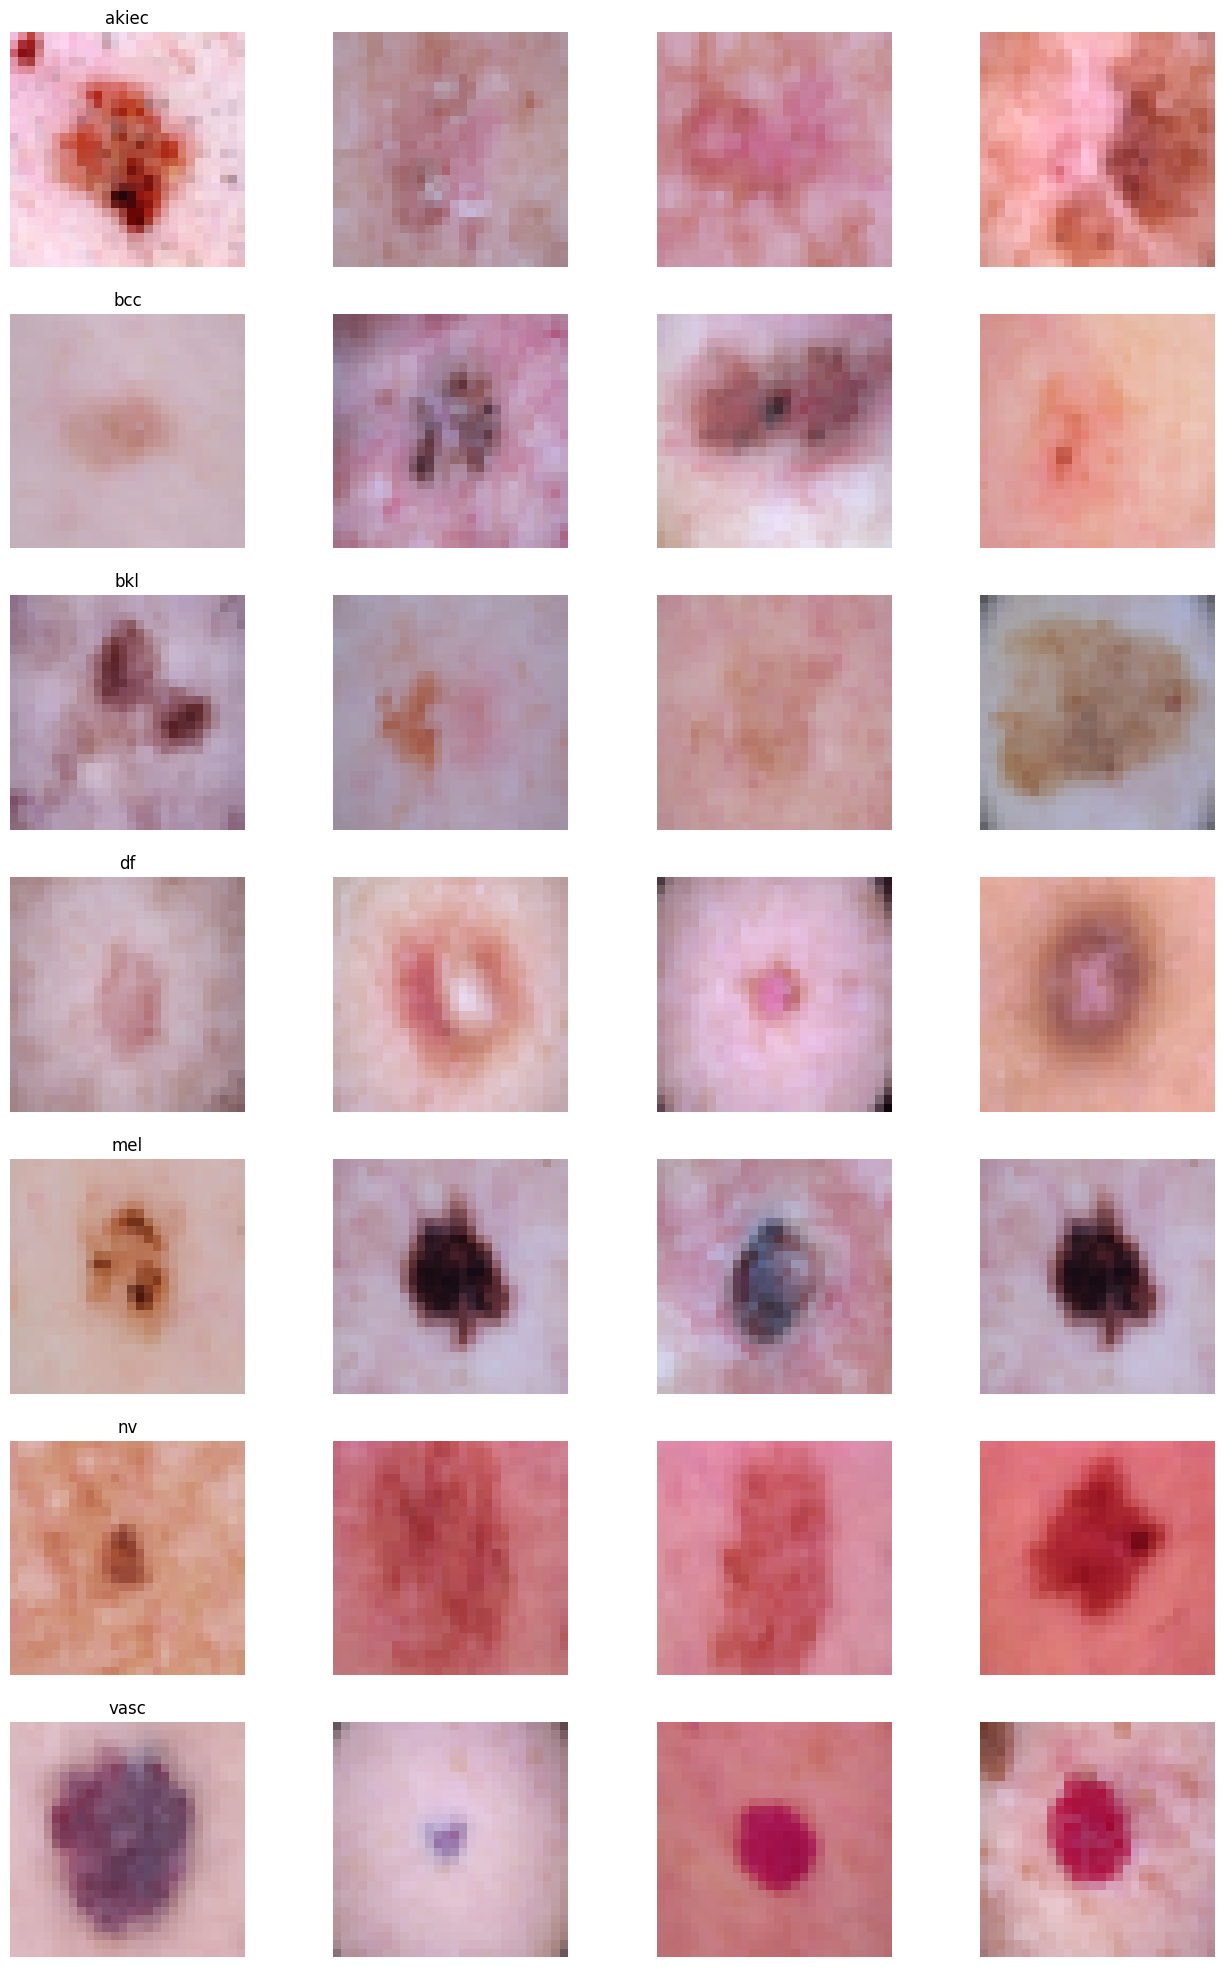

In [17]:
#ploting the images based on the new normalization
n_samples = 4 #number of sample for ploting

fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 25))

for c_ax, (type_name, type_rows) in zip(m_axs, df_balanced.sort_values(['dx']).groupby('dx')):
    c_ax[0].set_title(type_name)
    for (_, c_row), n_ax in zip(type_rows.sample(n_samples, random_state=1234).iterrows(), c_ax):
        n_ax.imshow(c_row['image'])
        n_ax.axis('off')

  

#Feature Extraction

In [18]:
#lets convert the dataframe to a numpy array in order to use it for our model design
#define x as 'image' column, which is the features
x = np.asarray(df_balanced['image'].tolist())

#rescale the values to 0-1 by dividing it by 255 (one-hot encoding)
x = x/255

#define y as label as the target variable that we want to predict.
y = df_balanced['label']

#since we have a multi-class classification problem, we have to categorize it
y_cat = to_categorical(y, num_classes=7)



In [19]:
#define the train, validation and test set
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.25, random_state=42)


In [20]:
x_train.shape



(2625, 28, 28, 3)

In [21]:
x_test.shape

(875, 28, 28, 3)

In [22]:
y_train.shape

(2625, 7)

In [23]:
y_test.shape


(875, 7)

#Model Development

In [24]:
#define the model
#CNN architecture

from keras.layers.pooling.max_pooling2d import MaxPool2D
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 128)         0

In [25]:
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.layers import Dense, Flatten, Dropout
#from tensorflow.keras.models import Model

# Load the VGG16 model without the top layers

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#num_classes = 7

# Freeze the base model's layers so they are not trainable

#for layer in base_model.layers:
 # layer.trainable = False

# Add new trainable layers on top of the frozen layers

#x = base_model.output
#x = Flatten()(x)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.3)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.3)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.3)(x)
#predictions = Dense(num_classes, activation='softmax')(x)

# Create the transfer learning model

#model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()


In [26]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0.0001)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1,save_best_only=True, mode='max')

#Model Training

In [ ]:
#train the model

history = model.fit(
    x_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[es,mc]
)

Epoch 1/40
164/165 [============================>.] - ETA: 0s - loss: 1.8879 - acc: 0.1986
Epoch 1: val_acc improved from -inf to 0.22857, saving model to best_model.hdf5
165/165 [==============================] - 29s 168ms/step - loss: 1.8878 - acc: 0.1985 - val_loss: 1.8196 - val_acc: 0.2286
Epoch 2/40
164/165 [============================>.] - ETA: 0s - loss: 1.6995 - acc: 0.2934
Epoch 2: val_acc improved from 0.22857 to 0.34057, saving model to best_model.hdf5
165/165 [==============================] - 29s 175ms/step - loss: 1.6996 - acc: 0.2933 - val_loss: 1.6031 - val_acc: 0.3406
Epoch 3/40
164/165 [============================>.] - ETA: 0s - loss: 1.5501 - acc: 0.3643
Epoch 3: val_acc improved from 0.34057 to 0.39200, saving model to best_model.hdf5
165/165 [==============================] - 29s 177ms/step - loss: 1.5500 - acc: 0.3646 - val_loss: 1.4875 - val_acc: 0.3920
Epoch 4/40
164/165 [============================>.] - ETA: 0s - loss: 1.4680 - acc: 0.4024
Epoch 4: val_acc i

#Model Evaluation and Testing


In [ ]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



In [ ]:
#accuracy curve

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#let test the model with some prediction

y_pred = model.predict(x_test)

#convert prediction classes to one-hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)

#convert test data to one-hot vectors
y_true = np.argmax(y_test, axis = 1)



In [ ]:
#examine the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=5, ax=ax)


In [ ]:
# Let's examine the incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig = go.Figure(
    data=[go.Bar(x=np.arange(7), y=incorr_fraction)],
    layout=go.Layout(xaxis=dict(title='True label'), yaxis=dict(title='Fraction of incorrect predictions'))
)

fig.show()


In [ ]:
# Select a random sample of 10 test_set and display the True label and predicted label
sample_indices = np.random.choice(len(x_test), size=12, replace=False)
x_sample = x_test[sample_indices]
y_sample = y_test[sample_indices]

# Use the model to make predictions on the sample
y_pred = model.predict(x_sample)

# Plot the images and print the true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()
for i in range(len(sample_indices)):
    axs[i].imshow(x_sample[i])
    axs[i].set_title(f"True: {np.argmax(y_sample[i])} : Pred: {np.argmax(y_pred[i])}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


# New Section